# Project description

You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

(The important thing is to get experience working with data. It doesn't really matter whether you're forecasting 2017 sales based on data from 2016 or 2027 sales based on data from 2026.)

The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

### Step 1. Open the data file and study the general information

In [641]:
import pandas as pd
import re
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
%matplotlib inline

In [483]:
games = pd.read_csv('/datasets/games.csv')

In [484]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Let's look at the general information about dataset

In [485]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [486]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [487]:
print('The number of duplicates: {}'.format(games.duplicated().sum()))

The number of duplicates: 0


In [488]:
print('The number of games in the dataset: {}'.format(games.shape[0]))

The number of games in the dataset: 16715


In [489]:
# Finally let's see at the value counts of all object columns
object_columns = (column for column in games.columns if games[column].dtype == 'object')
not_ratio_columns = ('Name',)
for column in object_columns:
    if column not in not_ratio_columns:
        print(games[column].value_counts(dropna=False, normalize=True))
    else:
        print(games[column].value_counts())
    print('*'*90)

Need for Speed: Most Wanted                      12
LEGO Marvel Super Heroes                          9
Madden NFL 07                                     9
Ratatouille                                       9
FIFA 14                                           9
                                                 ..
After Hours Athletes                              1
Momotarou Dentetsu 15                             1
Lilie no Atelier: Salburg no Renkinjutsushi 3     1
Fight Night Round 2004                            1
Incredible Crisis                                 1
Name: Name, Length: 11559, dtype: int64
******************************************************************************************
PS2     0.129285
DS      0.128687
PS3     0.079629
Wii     0.078971
X360    0.075501
PSP     0.072330
PS      0.071612
PC      0.058271
XB      0.049297
GBA     0.049177
GC      0.033264
3DS     0.031110
PSV     0.025725
PS4     0.023452
N64     0.019085
XOne    0.014777
SNES    0.014299
SAT     

### Conclusion

As we see, our dataset contains 16715 games in other genres, on other platforms and with other user and critic ratings.

A quick analysis has revealed that there is two games without names and two games without genres. I suppose that these are the same rows in the table and we will check it in the next section.

Also we have many missing values in the year of release and huge number of the missing values in the Critic_Score, User_Score and the Rating columns. My assumption about missing values in the last one is that NaN value means E ESRB rating because Super Mario Bros. and Pokemon Red/Pokemon Blue games has E ESRB rating. But we also should provide more precise analysis to conclude this.

I can't deal any assumption about missing values in the critic/user score columns yet, but my intuition says me that data have been taken from incomplete database. But I've found several games database api's and there is information about the first two NaN games (Super Mario Bros. and Pokemon) 

Yet there are some 'tbd' values in the User_Score column and it might tell us about updated database or may be the games with 'tbd' User_Score have revealed recently.

There is no any full duplicate in our dataset but in the Name column we have 14 rows with Need For Speed: Most Wanted title. It's obviously row for every platform for this game. It's interesting to analyse multiplatform games with these user/critic score and sales on different continents

### Step 2. Prepare the data

In [490]:
# At first let's lowercase our columns for convinience
games.columns = [column.lower() for column in games.columns]
print(games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


In [491]:
games.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

### Convert datatypes

In [492]:
# We should convert year of release to int64, user_score to float64 (because there is decimal scores)
# And critic_score to int64 if there is no any decimal score

# At first let's check if there is any decimal score in the critic_score column
if (games['critic_score'].value_counts().index.values * 10 % 10).sum() > 0: # We sum the remainders of the critic scores.
    print('There are some games with decimal critic scores')
else:
    print("There is no any game with decimal critic score! Let's convert it to int")

There is no any game with decimal critic score! Let's convert it to int


In [493]:
games['critic_score'] = games['critic_score'].astype('Int64')
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN


In [494]:
# To convert user_score to float we should deal with 'tbd' at first. We can replace it with zeros without losing
# any information but at first let's look that there is no any game with 0 user_score
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.5       2
0.9       2
1.1       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [495]:
# There is right one game with zero user_score, let's check it
games.query('user_score == "0"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
2835,My Little Pony: Pinkie Pie's Party,DS,2008.0,Adventure,0.66,0.0,0.0,0.06,<NA>,0,E


In [496]:
# I don't want to lose information about the pony game so I replace 'tbd' values with -1
# and it will be numerical identifier of it
games['user_score'].replace('tbd', -1, inplace=True)

In [497]:
games['user_score'] = games['user_score'].astype('float64')

In [498]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN


I've changed the type of the year_of_release, critic_score and the user_score columns:

I changed the first one for convinient year analysis and the year of release can't be float.

The second one was changed because critic score always is an int number

The user_score column was changed because of convinient data analysis: plot histograms, look at the descriptive statistics

### Working with missing values

In [499]:
def print_missing_statistics(table):
    number_of_missing_values = table.isna().sum()
    print(number_of_missing_values[number_of_missing_values != 0])

In [500]:
print_missing_statistics(games)

name                  2
year_of_release     269
genre                 2
critic_score       8578
user_score         6701
rating             6766
dtype: int64


In the first step of the project my assumption was that the rows with the missing name and the rows with the missing genre are the same. Let's check it.

In [501]:
games.query('name.isna() and genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


Hm, there are no name, genre, critic_score, user score or rating. And the most strange in these rows that the first one has na, eu and other sales and the second one has jp sales.

May be it's the same game but i can't deal any assumptions only on sales columns. And these rows will not help us in our analysis of average gamer profile on different regions. So we can just drop it becaus there is only two entries.

In [502]:
games.dropna(subset=['name', 'genre'], inplace=True)

In [503]:
print_missing_statistics(games)

year_of_release     269
critic_score       8576
user_score         6699
rating             6764
dtype: int64


In [504]:
# Now let's take a look at the year_of_release column
games_without_year_of_release = games.query('year_of_release.isna()').copy()
games_without_year_of_release.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,<NA>,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,<NA>,NaN,NaN


It looks like some games have their year of release in their names: Madden NFL 2004, FIFA Soccer 2004, etc. So we can filter the name column by regex and find all games with year in the name.

In [505]:
regex = r'.*\d{4}.*'
date_mask = games_without_year_of_release['name'].str.contains(regex)
games_without_year_of_release[date_mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84,6.4,E
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,<NA>,NaN,NaN
1650,NASCAR Thunder 2003,PS2,<NA>,Racing,0.60,0.46,0.00,0.16,84,8.7,E
2572,PES 2009: Pro Evolution Soccer,PSP,<NA>,Sports,0.04,0.33,0.26,0.17,<NA>,NaN,NaN
3486,Madden NFL 2002,XB,<NA>,Sports,0.53,0.02,0.00,0.03,90,8.1,E
4775,NFL GameDay 2003,PS2,<NA>,Sports,0.20,0.15,0.00,0.05,60,-1.0,E
5156,NBA Live 2003,XB,<NA>,Sports,0.31,0.04,0.00,0.01,82,8.8,E
5336,Tomb Raider (2013),PC,<NA>,Action,0.06,0.25,0.00,0.04,86,8.5,M
5655,All-Star Baseball 2005,PS2,<NA>,Sports,0.16,0.12,0.00,0.04,72,8.6,E


In [506]:
# Now let's fill year_of_release column with the year in the name
def fill_year_of_release(row):
    name = row['name']
    match = re.search('\d{4}', name)
    try:
        return int(name[match.start(): match.end()])
    except:
        return np.nan

In [507]:
games_without_year_of_release['year_of_release'] = games_without_year_of_release.apply(fill_year_of_release, axis=1)
games_without_year_of_release['year_of_release'] = games_without_year_of_release['year_of_release'].astype('Int64')

In [508]:
games_without_year_of_release.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2004,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,2004,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,2006,Fighting,1.57,1.02,0.00,0.41,<NA>,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,<NA>,NaN,NaN


In [509]:
games.query('name == "LEGO Batman: The Videogame"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
397,LEGO Batman: The Videogame,X360,2008,Action,2.04,1.02,0.0,0.32,76,7.9,E10+
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.0,0.29,74,7.9,E10+
460,LEGO Batman: The Videogame,DS,2008,Action,1.75,1.01,0.0,0.29,72,8.0,E10+
1519,LEGO Batman: The Videogame,PS3,2008,Action,0.72,0.39,0.0,0.19,75,7.7,E10+
1538,LEGO Batman: The Videogame,PSP,<NA>,Action,0.57,0.44,0.0,0.27,73,7.4,E10+
1553,LEGO Batman: The Videogame,PS2,2008,Action,0.72,0.03,0.0,0.52,77,8.9,E10+
12465,LEGO Batman: The Videogame,PC,2008,Action,0.02,0.03,0.0,0.01,80,7.8,E10+


It seems that some videogames without year of release has it in other platforms. Let's fill NaN values with appropriate values from other platforms.

In [510]:
games.query('name == "Space Invaders"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,<NA>,NaN,NaN
4264,Space Invaders,SNES,1994,Shooter,0.00,0.00,0.46,0.00,<NA>,NaN,NaN
8580,Space Invaders,N64,1999,Shooter,0.13,0.03,0.00,0.00,<NA>,NaN,NaN
10383,Space Invaders,GBA,2002,Shooter,0.08,0.03,0.00,0.00,<NA>,NaN,NaN


But if we look at space invaders, we see that the game has released in different years with respect to platforms. And as wikipedia says :["The 1980 Atari VCS version quadrupled sales of the VCS"](](https://en.wikipedia.org/wiki/Space_Invaders)) which means that year of release is 1980

In [511]:
game_names_without_year_of_release = games_without_year_of_release.query('year_of_release.isna()')['name'].unique()
print('The number of games without year of release: {}'.format(len(game_names_without_year_of_release)))

The number of games without year of release: 218


In [512]:
# Let's look how many games with year_of_release have cross-platforming
game_names_with_year_of_release = games.query('name.isin(@game_names_without_year_of_release) and not year_of_release.isna()')['name'].unique()
print('The number of games from "games withour year" list which have cross platforms: {}'.format(len(game_names_with_year_of_release)))

The number of games from "games withour year" list which have cross platforms: 91


In [513]:
games_without_year_and_cross = set(list(game_names_without_year_of_release)).difference(set(list(game_names_with_year_of_release)))
print('The number of games without analogue on other platforms with filled year of release: {}'.format(len(games_without_year_and_cross)))

The number of games without analogue on other platforms with filled year of release: 127


In [514]:
# Let's define function which will assign to game the mode of year of release among its cross platforms versions.
# If every number is unique as in Space Invader case, mode()[0] method will return the first release date,
# and it's logic assumption I suppose
def get_year_of_release_by_cross_platforms(row, games):
    name = row['name']
    year = row['year_of_release']
    if year is not np.nan:  # to skip already filled
        return year
    try:
        return games.query('name == @name')['year_of_release'].mode()[0]
    except:
        return np.nan

In [515]:
games_without_year_of_release['year_of_release'] = games_without_year_of_release.apply(get_year_of_release_by_cross_platforms, axis=1, args=(games,))
games_without_year_of_release['year_of_release'] = games_without_year_of_release['year_of_release'].astype('Int64')

In [516]:
games_without_year_of_release.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2004,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,2004,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,2006,Fighting,1.57,1.02,0.00,0.41,<NA>,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,<NA>,NaN,NaN


In [517]:
games_without_year_of_release.query('year_of_release.isna()')['name'].shape[0]

252

It seems that now we have 139 games without year of release and cross platforms. It strange, because our calculations show that we should have only 127 games now. Let's look a bit closer . . .

In [518]:
games_without_year_of_release.query('year_of_release.isna()')['name'].unique().shape[0]

218

Of course! If we look at the unique names, there are the same 127 games. It means that we have some games which haven't year of release on several platforms

In [519]:
games_without_year_of_release.query('year_of_release.isna()').head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.0,0.29,74,7.9,E10+
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.0,0.03,<NA>,NaN,NaN
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.0,0.21,92,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.0,0.07,73,-1.0,E
678,LEGO Indiana Jones: The Original Adventures,Wii,<NA>,Action,1.51,0.61,0.0,0.21,78,6.6,E10+
719,Call of Duty 3,Wii,<NA>,Shooter,1.17,0.84,0.0,0.23,69,6.7,T
805,Rock Band,Wii,<NA>,Misc,1.33,0.56,0.0,0.20,80,6.3,T
1131,Call of Duty: Black Ops,PC,<NA>,Shooter,0.58,0.81,0.0,0.23,81,5.2,M
1142,Rock Band,PS3,<NA>,Misc,0.99,0.41,0.0,0.22,92,8.4,T
1301,Triple Play 99,PS,<NA>,Sports,0.81,0.55,0.0,0.10,<NA>,NaN,NaN


Now I really can't figure out what I can do with the rest of missing values just looking at the data. But I've found one site. Its name is [RAWG Video Game Database](https://rawg.io/). And on the site you can find information about any game (include its year of release, rating and may be critic score and user score) I don't know if it's cheating because in real life problem you would use any tools which would be available for you to deal real useful things for your company and your business 

In [520]:
# At first let's test the API
url = 'https://api.rawg.io/api/games'
params = {'search': 'Rock Band'}
response = requests.get(url, params=params)

In [521]:
result = response.json()['results'][0]

In [522]:
games.query('name == "Rock Band"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.0,0.21,92,8.2,T
805,Rock Band,Wii,<NA>,Misc,1.33,0.56,0.0,0.20,80,6.3,T
1142,Rock Band,PS3,<NA>,Misc,0.99,0.41,0.0,0.22,92,8.4,T
1840,Rock Band,PS2,<NA>,Misc,0.71,0.06,0.0,0.35,82,6.8,T


In [523]:
result['platforms']

[{'platform': {'id': 14, 'name': 'Xbox 360', 'slug': 'xbox360'}},
 {'platform': {'id': 16, 'name': 'PlayStation 3', 'slug': 'playstation3'}},
 {'platform': {'id': 15, 'name': 'PlayStation 2', 'slug': 'playstation2'}},
 {'platform': {'id': 11, 'name': 'Wii', 'slug': 'wii'}}]

In [524]:
# Seems that it works! Let's look at the release date
result['released']

'2007-11-20'

Also let's look at the full information about game. May be we could fill all the gaps in our table

In [525]:
result

{'slug': 'rock-band',
 'name': 'Rock Band',
 'playtime': 33,
 'platforms': [{'platform': {'id': 14, 'name': 'Xbox 360', 'slug': 'xbox360'}},
  {'platform': {'id': 16, 'name': 'PlayStation 3', 'slug': 'playstation3'}},
  {'platform': {'id': 15, 'name': 'PlayStation 2', 'slug': 'playstation2'}},
  {'platform': {'id': 11, 'name': 'Wii', 'slug': 'wii'}}],
 'stores': [{'store': {'id': 3,
    'name': 'PlayStation Store',
    'slug': 'playstation-store'}},
  {'store': {'id': 6, 'name': 'Nintendo Store', 'slug': 'nintendo'}},
  {'store': {'id': 7, 'name': 'Xbox 360 Store', 'slug': 'xbox360'}}],
 'released': '2007-11-20',
 'tba': False,
 'background_image': 'https://media.rawg.io/media/screenshots/592/5923a46e97752379c39c4a8a391feedc.jpg',
 'rating': 4.13,
 'rating_top': 4,
 'ratings': [{'id': 4, 'title': 'recommended', 'count': 61, 'percent': 58.1},
  {'id': 5, 'title': 'exceptional', 'count': 33, 'percent': 31.43},
  {'id': 3, 'title': 'meh', 'count': 7, 'percent': 6.67},
  {'id': 1, 'title':

We see that there is 'rating' field and it looks like user score but in range 0 to 5. We can fill the missing values in the user score column with the mean/median value from other platforms. But if there will be some games without user score, we can just fill it up with this database.

Also there is no any information about sales, critic score or ESRB rating.

Yet there is 'genres' field and this genres doesn't match with table genres so we can't use the genre column for search with the API

In [526]:
# Ok. Now let's define a function to fill the release date
def get_year_of_release_via_rawg(row, url):
    name = row['name']
    year_of_release = row['year_of_release']
    if year_of_release is not np.nan:
        return year_of_release
    url = 'https://api.rawg.io/api/games'
    params = {'search': name}
    try:
        result = requests.get(url, params=params).json()['results'][0]
    except Exception as e:  # for unexpectable network errors
        return np.nan
    else:
        try:
            return int(result['released'][:4])
        except:
            return np.nan

In [527]:
games_without_year_of_release['year_of_release'] = games_without_year_of_release.apply(get_year_of_release_via_rawg, axis=1, args=(url,))
games_without_year_of_release['year_of_release'] = games_without_year_of_release['year_of_release'].astype('Int64')

In [528]:
games_without_year_of_release.query('name == "Rock Band"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.0,0.21,92,8.2,T
805,Rock Band,Wii,<NA>,Misc,1.33,0.56,0.0,0.20,80,6.3,T
1142,Rock Band,PS3,<NA>,Misc,0.99,0.41,0.0,0.22,92,8.4,T
1840,Rock Band,PS2,<NA>,Misc,0.71,0.06,0.0,0.35,82,6.8,T


Now let's look at the rest of null values

In [529]:
games_without_year_of_release.query('year_of_release.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,<NA>,NaN,NaN
627,Rock Band,X360,<NA>,Misc,1.93,0.33,0.00,0.21,92,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,<NA>,Adventure,2.15,0.18,0.00,0.07,73,-1.0,E
678,LEGO Indiana Jones: The Original Adventures,Wii,<NA>,Action,1.51,0.61,0.00,0.21,78,6.6,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16348,Agarest Senki: Re-appearance,PS3,<NA>,Role-Playing,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16405,Freaky Flyers,GC,<NA>,Racing,0.01,0.00,0.00,0.00,69,6.5,T
16448,Inversion,PC,<NA>,Shooter,0.01,0.00,0.00,0.00,59,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,<NA>,Adventure,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


There are just 8 games without year of release, but I am sure that I can find this information in the Internet

- Yu Yu Hakusho: Dark Tournament - 2004
- Ghostbusters II - 1989
- Demon Chaos - 2005
- McFarlane's Evil Prophecy	- 2004
- Combat Elite: WWII Paratroopers - 2005
- Fullmetal Alchemist: Brotherhood - 2010
- Super Duper Sumos - 2003

In [530]:
years = (2004, 1989, 2005, 2004, 2005, 2010, 2005, 2003)
games_without_year = games_without_year_of_release.query('year_of_release.isna()')['name']
games_to_year = dict(zip(list(games_without_year), years))

In [531]:
games_to_year

{'LEGO Batman: The Videogame': 2004,
 'Space Invaders': 1989,
 'Rock Band': 2005,
 "Frogger's Adventures: Temple of the Frog": 2004,
 'LEGO Indiana Jones: The Original Adventures': 2005,
 'Call of Duty 3': 2010,
 'Call of Duty: Black Ops': 2003}

In [532]:
def fill_rest_games_without_year(row, games_to_year):
    name = row['name']
    year_of_release = row['year_of_release']
    if year_of_release is not np.nan:
        return year_of_release
    return games_to_year[name]

In [533]:
games_without_year_of_release['year_of_release'] = games_without_year_of_release.apply(fill_rest_games_without_year, axis=1, args=(games_to_year, ))


In [534]:
print('The number of games without year of release: {}'.format(games_without_year_of_release.query('year_of_release.isna()').shape[0]))

The number of games without year of release: 252


In [535]:
# Now let's replace original games without year of release with our new dataframe
games.update(games_without_year_of_release)

In [536]:
print('The number of games without year of release: {}'.format(games.query('year_of_release.isna()').shape[0]))

The number of games without year of release: 252


In [537]:
print_missing_statistics(games)

year_of_release     252
critic_score       8576
user_score         6699
rating             6764
dtype: int64


Now we have missing critic/user score and rating. Let's deal with it like with cross platform strategy

In [538]:
games_without_critic_score = games.query('critic_score.isna()')

In [539]:
games_without_critic_score

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


In [540]:
# Now let's check unique names
game_names_without_cs = games_without_critic_score['name'].unique()
print('The unique number of games without critic score: {}'.format(game_names_without_cs.shape[0]))

The unique number of games without critic score: 7122


In [541]:
# Now let's check how many of these games have cross platform analogues with filled critic scores
game_names_with_cs = games.query('name.isin(@game_names_without_cs) and not critic_score.isna()')['name'].unique()

In [542]:
print('The unique number of games with cs and cross-platforms: {}'.format(game_names_with_cs.shape[0]))

The unique number of games with cs and cross-platforms: 648


But on the other hand there are cases where a game have higher score on one platform than on another. It may be related with platform restrictions (30 FPS, inconvinient hero control, etc.) Or it may be bagged port on PC. So I think, that we can't deal any assumptions about critic or user score. 

As example, there is The Spider Man 2 (2004) on different platforms and it has 42 points on Metacritic [on PC](https://www.metacritic.com/game/pc/spider-man-2-the-game) and 80 points [on PS2](https://www.metacritic.com/game/playstation-2/spider-man-2)

So we leave critic and user score as is and go to our data engineer to ask them where our valid data are. 

In [543]:
# Finally let's look at the rating column
games_without_rating = games.query('rating.isna()')
games_without_rating.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,<NA>,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,<NA>,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,NaN


In [544]:
games_without_rating.query('year_of_release > 2000')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,<NA>,NaN,NaN
20,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,6.38,4.46,6.04,1.36,<NA>,NaN,NaN
25,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,6.06,3.90,5.38,0.50,<NA>,NaN,NaN
27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,<NA>,NaN,NaN
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,<NA>,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,<NA>,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,<NA>,NaN,NaN


At the beginning my assumption was that all games with missing rating have E ESRB rating, but there is Call of Duty: Black Ops 3, which has M ESRB rating, so we can't just fill missing values with E rating. 

In [545]:
# Let's check all the Call of Duty games. May be some of them have rating
games_without_rating[games_without_rating['name'].str.contains('Call of Duty')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,<NA>,NaN,NaN
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,<NA>,NaN,NaN
1036,Call of Duty: World at War Final Fronts,PS2,2008,Shooter,0.61,0.18,0.00,0.94,<NA>,NaN,NaN
1049,Call of Duty: Black Ops 3,X360,2015,Shooter,1.14,0.40,0.00,0.16,<NA>,NaN,NaN
1062,Call of Duty: Black Ops 3,PS3,2015,Shooter,0.49,0.87,0.07,0.26,<NA>,NaN,NaN
1245,Call of Duty: Modern Warfare: Reflex Edition,Wii,2009,Shooter,0.94,0.43,0.00,0.14,<NA>,NaN,NaN
2916,Call of Duty: Ghosts,PC,2013,Shooter,0.23,0.41,0.00,0.05,<NA>,NaN,NaN
4690,Call of Duty: Modern Warfare: Mobilized,DS,2009,Shooter,0.36,0.02,0.00,0.03,<NA>,NaN,NaN
6463,Call of Duty: Black Ops 3,PC,2015,Shooter,0.00,0.25,0.00,0.01,<NA>,NaN,NaN
6542,Call of Duty: Modern Warfare 3: Defiance,DS,2011,Shooter,0.19,0.04,0.00,0.02,<NA>,NaN,NaN


Unfortunately, no. So, let's look at all "shooter" games with rating

In [546]:
games_without_rating.query('genre == "Shooter" and not rating.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Hmmm... There is no any shooter game with rating. 

So we can't deal any assumptions about game ratings, and let's analyse the rest of we have

In [547]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [548]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,<NA>,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,<NA>,NaN,NaN,31.38


### Conclusion

1. We cast columns to lower case for convinience and converted several column to appropriate data types
2. Also we worked out with missing values and use not only data in the table but data from external sources (rawg DATABASE)
3. Yet we calculated total sales for every game

### Step 3. Analyze the data

#### Let's look at how many games were released in different years

In [549]:
games_per_year = games.pivot_table(index='year_of_release', values=['total_sales'], aggfunc=['count', 'sum'])
games_per_year.columns = ['count', 'total_sales']

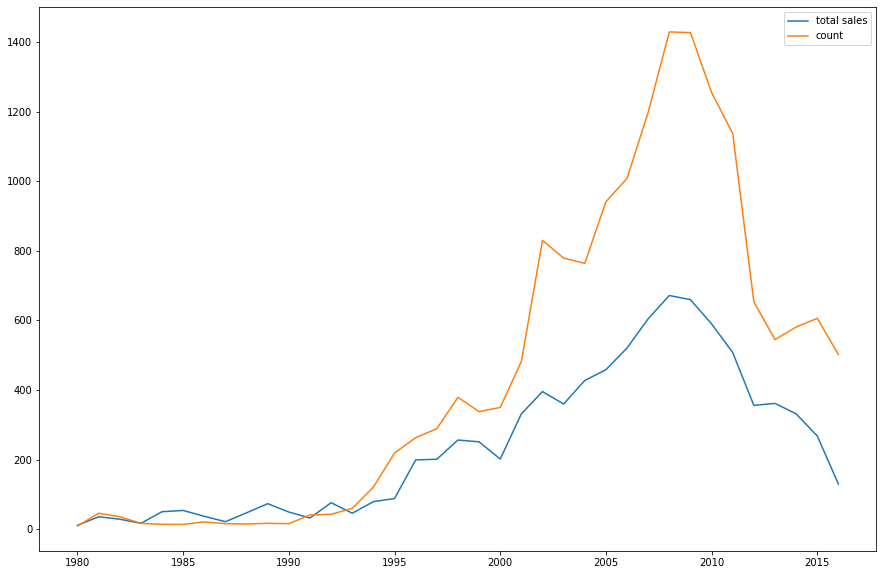

In [550]:
fig, ax = plt.subplots(figsize=(15, 10))
x = games_per_year.index
y_1 = games_per_year['total_sales']
y_2 = games_per_year['count']
ax.plot(x, y_1, label='total sales')
ax.plot(x, y_2, label='count')
ax.legend()
plt.show()

In [551]:
games_per_year.tail(10)

,count,total_sales
year_of_release,,
2007,1198,604.76
2008,1429,671.52
2009,1427,659.62
2010,1255,590.13
2011,1137,507.63
2012,653,355.84
2013,545,361.59
2014,581,331.53
2015,606,267.98


We see growth of games number and their total sales. But in 2012 we have sharp decline of number of games. It may be related with some economic crisis may be or crisis only in game industry. 

Or may be it was the beginning of AAA-games era. And to do the game, you can't deal a mistake and should work a lot on a project. 

#### Let's look at how sales varied from platform to platform. Choose the platforms with the greatest total sales and build a distribution based on data for each year. Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

In [552]:
games_per_platform = games.pivot_table(index='platform', values=['total_sales'], aggfunc=['count', 'sum'])
games_per_platform.columns = ['count', 'total_sales']
games_per_platform.sort_values('total_sales', ascending=False, inplace=True)
games_per_platform.head()

,count,total_sales
platform,,
PS2,2161,1255.77
X360,1262,971.42
PS3,1331,939.65
Wii,1320,907.51
DS,2151,806.12


In [553]:
games_per_platform_and_year = games.pivot_table(index='platform', columns='year_of_release', values=['total_sales'], aggfunc=['sum'])
games_per_platform_and_year.columns = [i for i in range(1980, 2017)]
games_per_platform_and_year.head()

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
2600,11.38,35.68,28.88,5.84,0.27,0.45,0.67,1.94,0.74,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.02,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,146.94,145.32,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN


In [554]:
games_per_platform_and_year['total_sales'] = games_per_platform_and_year.sum(axis=1)

In [555]:
games_per_platform_and_year.sort_values('total_sales', ascending=False, inplace=True)

In [556]:
games_per_platform_and_year.head(6)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,total_sales
platform,,,,,,,,,,,,,,,,,,,,,
PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN,1247.28
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,135.26,120.29,170.03,143.89,99.74,88.58,34.74,11.96,1.52,961.30
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60,931.34
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18,891.18
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,145.32,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN,802.79
PS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,727.58


In [557]:
def plot_platform_year_sales(games, number_of_top, year_columns):
    fig, ax = plt.subplots(figsize=(15, 10))
    for i in range(number_of_top):
        platform_name = games.iloc[i].name
        platform_games = games[games.index == platform_name]
        ax.plot(year_columns, platform_games[year_columns].values.T, '-o',label=platform_name)
        ax.legend()
    plt.grid()
    plt.show()

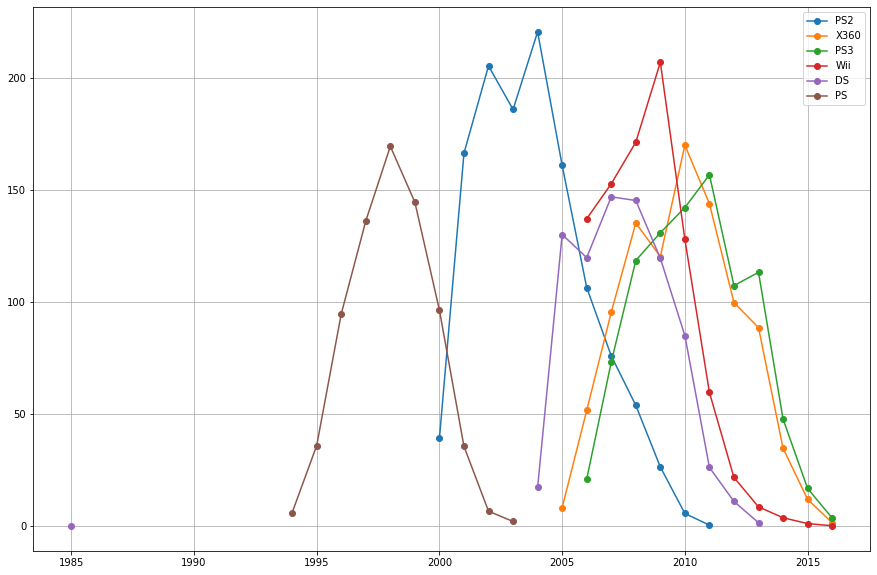

In [558]:
plot_platform_year_sales(games_per_platform_and_year, 6, games_per_platform_and_year.columns[:-1])

It seems like it takes about 10-12 years for platform to appear and fade.

For new platforms we see that it takes around 4-6 year to peak sales. 

For old platforms it takes around the same to fade.

All of these platforms have about zero sales now. But if we talk about modern platforms, these are PS3, XBOX360, Wii. It may be related with PS4 and XOne, new generation of consoles. But they were released in 2013 and it may talk about new console generation become popular through 3-4 years.

Let's look a bit closer at PlayStation appears and fades in different generations

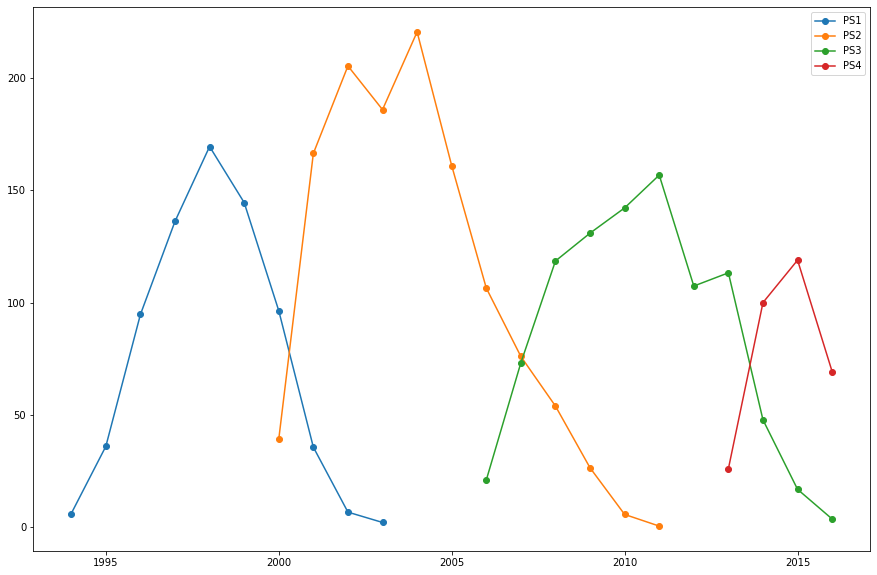

In [559]:
fig, ax = plt.subplots(figsize=(15, 10))

year_columns = [i for i in range(1980, 2017)]
ps = games_per_platform_and_year.query('platform == "PS"')
rest_ps = [games_per_platform_and_year.query('platform == "PS{}"'.format(i)) for i in range(2, 5)]
pss = [ps] + rest_ps

for i, ps in enumerate(pss):
    ax.plot(year_columns, ps[year_columns].T, '-o',label='PS{}'.format(i+1))
    ax.legend()

We see that every PS generation has taken about 3-4 years to become popular than previous one.

Let's take a quick look at the Microsoft

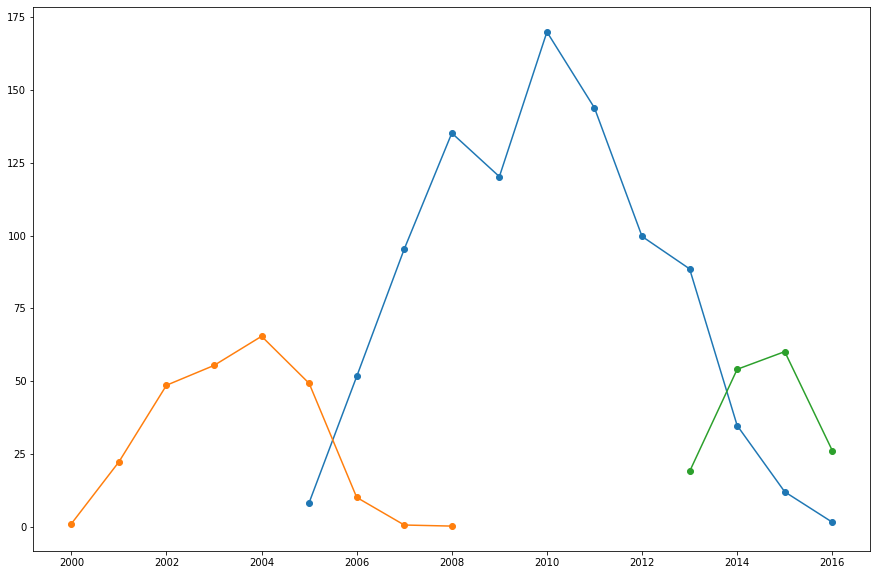

In [560]:
microsoft_platforms = ['X360', 'XB', 'XOne']
year_columns = [i for i in range(1980, 2017)]
microsoft_games = [games_per_platform_and_year.query('platform == "{}"'.format(microsoft_platform)) for microsoft_platform in microsoft_platforms]

fig, ax = plt.subplots(figsize=(15, 10))
for i, mc in enumerate(microsoft_games):
    ax.plot(year_columns, mc[year_columns].T, '-o', label=mc)

Even for microsoft it takes around 3-4 years! 

Also, as for PlayStation family, there is two peaks trend after first console generation. As these companies are main competitors, I suppose their total sales of each year are related. So we can expect another one sales peak on XOne and PS4. 

So, even if new generation of consoles is released, you can aim to previous one for at least two years.

But it works only on platforms with family. For example Wii has not so number of generations and it's not perspective platform for gaming.

Game trend has changed from 2000, and the main part of games and sales is between 2004 and 2016, but now we have eighth generation of consoles, so such platforms as PS2, XB, etc. are not relevant to take them into account. Let's take a period from seventh generation of consoles (X360, PS3, etc.) to make relevant forecast

In [561]:
relevant_columns = [i for i in range(2006, 2017)]

In [562]:
games_per_platform_and_year = games_per_platform_and_year[relevant_columns].copy()

In [563]:
games_per_platform_and_year['total_sales'] = games_per_platform_and_year.sum(axis=1)
games_per_platform_and_year.sort_values('total_sales', ascending=False, inplace=True)

games_per_platform_and_year.head(10)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,total_sales
platform,,,,,,,,,,,,
X360,51.62,95.42,135.26,120.29,170.03,143.89,99.74,88.58,34.74,11.96,1.52,953.05
PS3,20.96,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60,931.34
Wii,137.15,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18,891.18
DS,119.81,146.94,145.32,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN,655.36
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25,314.14
PS2,106.46,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN,268.84
3DS,NaN,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14,257.81
PSP,55.32,46.93,34.56,38.58,35.04,17.82,7.69,3.14,0.24,0.12,NaN,239.44
PC,2.85,9.28,12.42,16.91,24.28,35.03,23.22,12.73,13.28,8.52,5.25,163.77


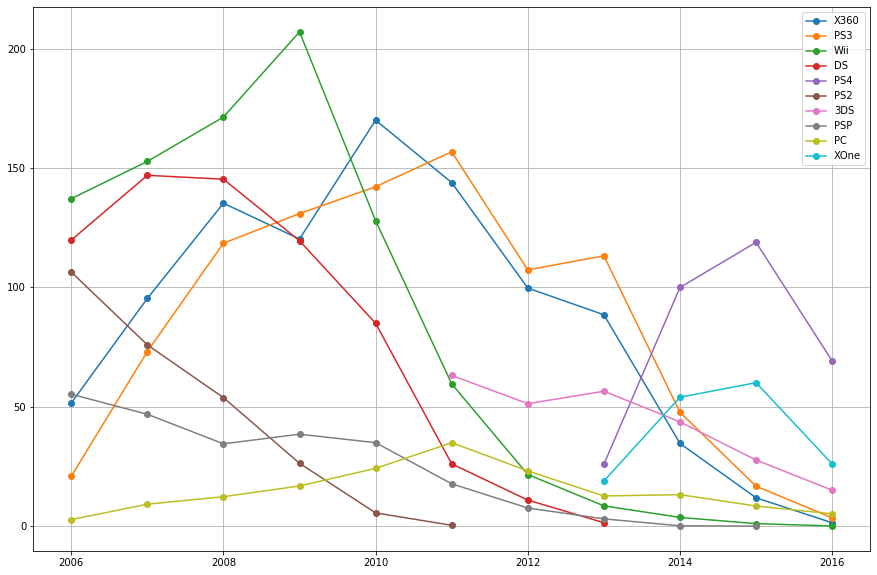

In [564]:
plot_platform_year_sales(games_per_platform_and_year, 10, games_per_platform_and_year.columns[:-1])

The most perspective platforms is PS4, XOne and 3DS. Also from my personal experience PC is a perspective platform, but I don't understand why sales are shrinking. 

Also I can't see any sales growing in any platforms, but I see that XOne and PS4 have passed only first peak of sales.

Finally, my choice is: PS4, XOne, 3DS, PC

#### Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.

In [565]:
profitable_platforms = ['PS4', 'XOne', '3DS', 'PC']

In [566]:
platform_to_sales = {profitable_platform: games.query('platform == "{}"'.format(profitable_platform))['total_sales'] for profitable_platform in profitable_platforms}

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


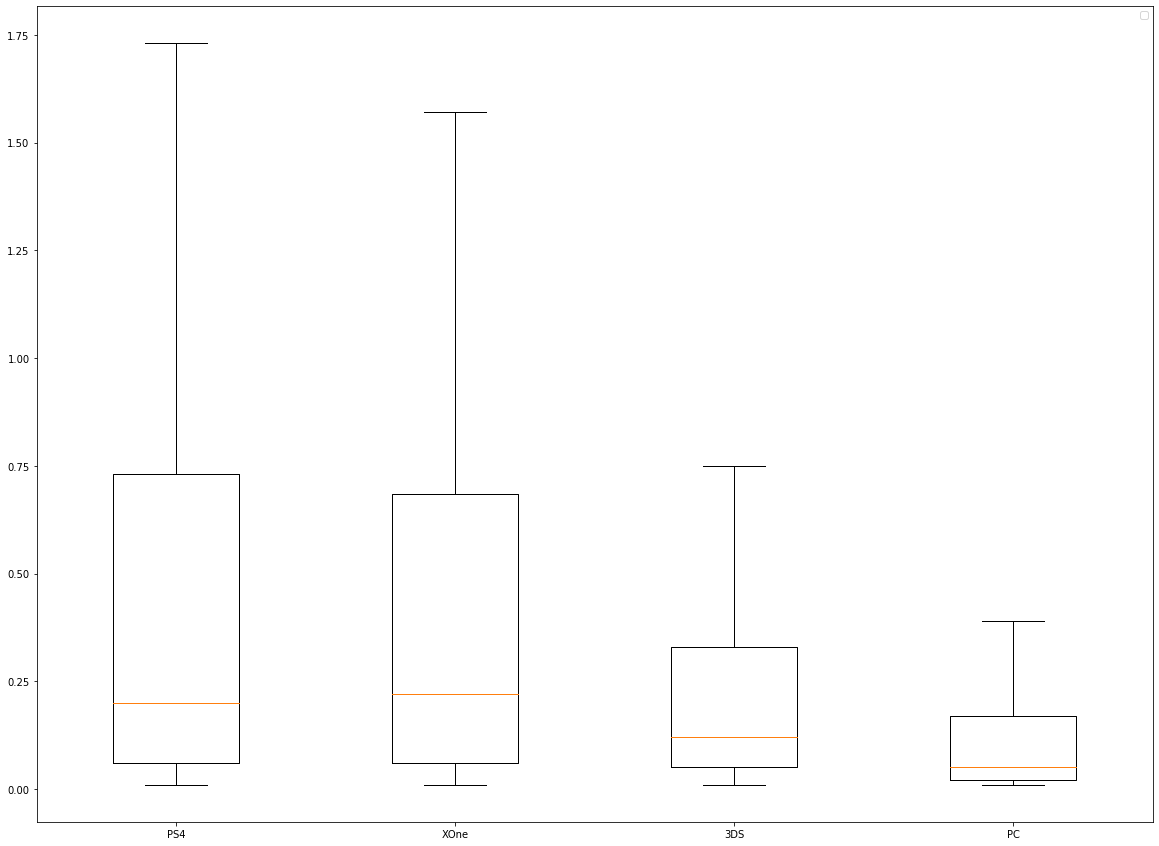

In [567]:
_, ax = plt.subplots(figsize=(20,15))
ax.boxplot(platform_to_sales.values(), showfliers=False, labels=platform_to_sales.keys())
ax.legend()
plt.show()

It seems like that PS4 is the richest platform although XOne has bigger median value, the first one has more spreaded distribution. PC is the worst gaming platform (Suppose it's related with torrents and cyber pirats) :(

#### Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

Let's take a bit closer on sales on PS4. It's one of the most popular platform!

In [595]:
ps4_games = games.query('platform == "PS4" and not user_score.isna() and not critic_score.isna()')

In [596]:
# At first let's plot a scatter plot between sales and user score
def scatter_plot_with_least_squared_regression(x, y):
    coef = np.polyfit(x,y,1)
    poly1d_y = np.poly1d(coef)
    plt.plot(x, y, 'yo', x, poly1d_y(x), '--k')
    plt.show()

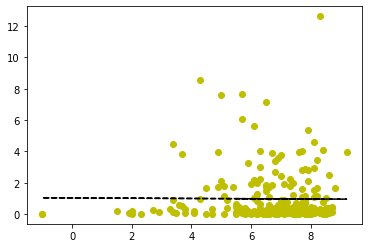

In [597]:
x = ps4_games['user_score']
y = ps4_games['total_sales']
scatter_plot_with_least_squared_regression(x, y)

In [598]:
# Now let's check coefficient of correlation
ps4_games['user_score'].corr(ps4_games['total_sales'])

-0.008016379854488059

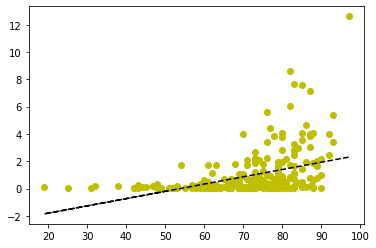

In [599]:
x = ps4_games['critic_score'].astype('float64')
scatter_plot_with_least_squared_regression(x, y)

In [600]:
x.corr(y)  # Pierson correlation between critic score and total sales

0.40600211593500984

 Now we see that there is more stronger dependence between critic score and total sales

The most games (critic score < 70) doesn't have an effect from scores. But the best games have a significant correlation. Let's take a look at these games on another profitable platforms.

In [601]:
best_critic_games = ps4_games.query('critic_score > 70')

In [602]:
best_critic_games_names = best_critic_games.sort_values('total_sales', ascending=False)['name'].values

In [607]:
best_critic_games = games.pivot_table(index='name', columns='platform', values=['total_sales'], aggfunc='sum').query('name.isin(@best_critic_games_names)')
best_critic_games.columns = best_critic_games.columns.get_level_values(1)
best_critic_games.drop(columns=best_critic_games.columns.difference(profitable_platforms), inplace=True)
best_critic_games.query('not PS4.isna() and not XOne.isna() and not PC.isna()').sort_values('PS4', ascending=False).head(10)

platform,3DS,PC,PS4,XOne
name,,,,
Grand Theft Auto V,NaN,1.17,12.62,5.47
FIFA 16,NaN,0.20,8.58,3.25
Call of Duty: Advanced Warfare,NaN,0.41,7.66,5.26
FIFA 17,NaN,0.12,7.60,2.65
Fallout 4,NaN,1.28,7.17,4.22
FIFA 15,0.46,0.29,6.08,2.18
Call of Duty: Infinite Warfare,NaN,0.13,4.47,2.42
Battlefield 1,NaN,0.38,4.07,2.25
Watch Dogs,NaN,0.44,4.05,1.57


We see that PS4 platform has the most sales and it's very profitable platform. 

#### Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

In [608]:
genre_games = games.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'count'])
genre_games.columns = ['total_sales', 'count']
genre_games.head()

,total_sales,count
genre,,
Action,1744.17,3369
Adventure,237.59,1303
Fighting,447.53,849
Misc,802.51,1750
Platform,827.77,888


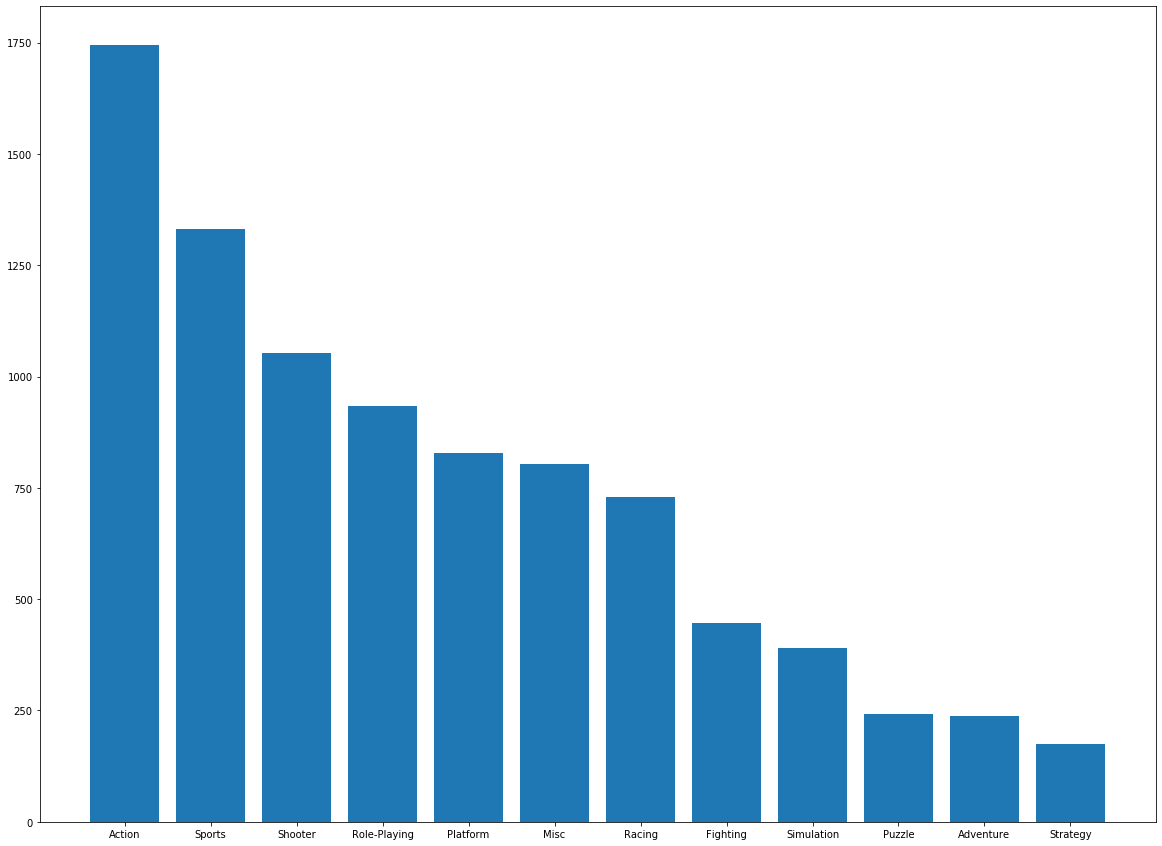

In [615]:
_, ax = plt.subplots(figsize=(20, 15))
genre_games.sort_values('total_sales', ascending=False, inplace=True)
ax.bar(genre_games.index, genre_games['total_sales'])
plt.show()

The most profitable genre is action. It followed by sports, shooter and RPG.

Let's see how profitable is Action on ps4

In [619]:
(games
    .query('platform == "PS4"')
    .pivot_table(index='genre', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending=False)
    .head())

,total_sales
genre,
Action,96.10
Shooter,88.56
Sports,55.61
Role-Playing,28.99
Racing,12.14


### Conclusion

The most profitable genre is Action, the most non-profitable is Strategy. I suppose that games with big involvement in itself has a more big profit. It's because in our love we more love action, sports, etc. more than puzzles and strategy.

### Step 4. Create a user profile for each region

In [623]:
# at first let's take only relevant years
games = games.query('year_of_release >= 2006')

In [637]:
regions = ['na', 'eu', 'jp']
def get_total_sales_by_param(games, region, param):
    return games.pivot_table(index=param, values='{}_sales'.format(region), aggfunc='sum').sort_values('{}_sales'.format(region), ascending=False).head()

In [638]:
platforms = [get_total_sales_by_param(games, region, 'platform') for region in regions]
for region, platforms in zip(regions, platforms):
    print('Top 5 {} platforms:\n {}\n'.format(region.upper(), platforms))

Top 5 NA platforms:
           na_sales
platform          
X360        588.84
Wii         486.87
PS3         390.13
DS          324.00
PS2         116.46

Top 5 EU platforms:
           eu_sales
platform          
PS3         327.21
X360        267.94
Wii         258.32
DS          142.99
PS4         141.09

Top 5 JP platforms:
           jp_sales
platform          
DS          141.49
3DS         100.62
PS3          79.41
PSP          70.89
Wii          68.28



It seems that the most users of NA play of X360, Wii and PS3. EU users prefer PS3 at first, then X360 and then Wii. 

JP users are the most different. They love play on portable devices, but we also have PS3 here.

Wii platform are popular on all continents.

In [639]:
genres = [get_total_sales_by_param(games, region, 'genre') for region in regions]
for region, genre in zip(regions, genres):
    print('Top 5 {} genres:\n {}\n'.format(region.upper(), genre))

Top 5 NA genres:
               na_sales
genre                 
Action          530.50
Sports          396.70
Shooter         373.13
Misc            285.06
Role-Playing    199.63

Top 5 EU genres:
          eu_sales
genre            
Action     350.95
Sports     251.89
Shooter    238.89
Misc       146.88
Racing     113.43

Top 5 JP genres:
               jp_sales
genre                 
Role-Playing    170.38
Action          102.07
Misc             64.53
Sports           49.23
Platform         35.20



All 3 regions like Action, but Shooter is not event in top5 JP genres. But JP players like Platform (Hi, Mario!)

In [640]:
esrb_ratings = [get_total_sales_by_param(games, region, 'rating') for region in regions]
for region, ratings in zip(regions, esrb_ratings):
    print('Top 5 {} ratings:\n {}\n'.format(region.upper(), ratings))

Top 5 NA ratings:
         na_sales
rating          
E         796.98
M         574.39
T         424.14
E10+      315.41
EC          1.32

Top 5 EU ratings:
         eu_sales
rating          
E         461.09
M         399.15
T         235.44
E10+      173.35
RP          0.03

Top 5 JP ratings:
         jp_sales
rating          
E         120.36
T          83.90
M          43.79
E10+       36.57
EC          0.00



The most profitable rating is E - everyone, it followed by teen and mature. But early childhood is the most non-profitable rating and E10+ is not so profitable as we expected.

At last let's check boxplots of total sales by regions

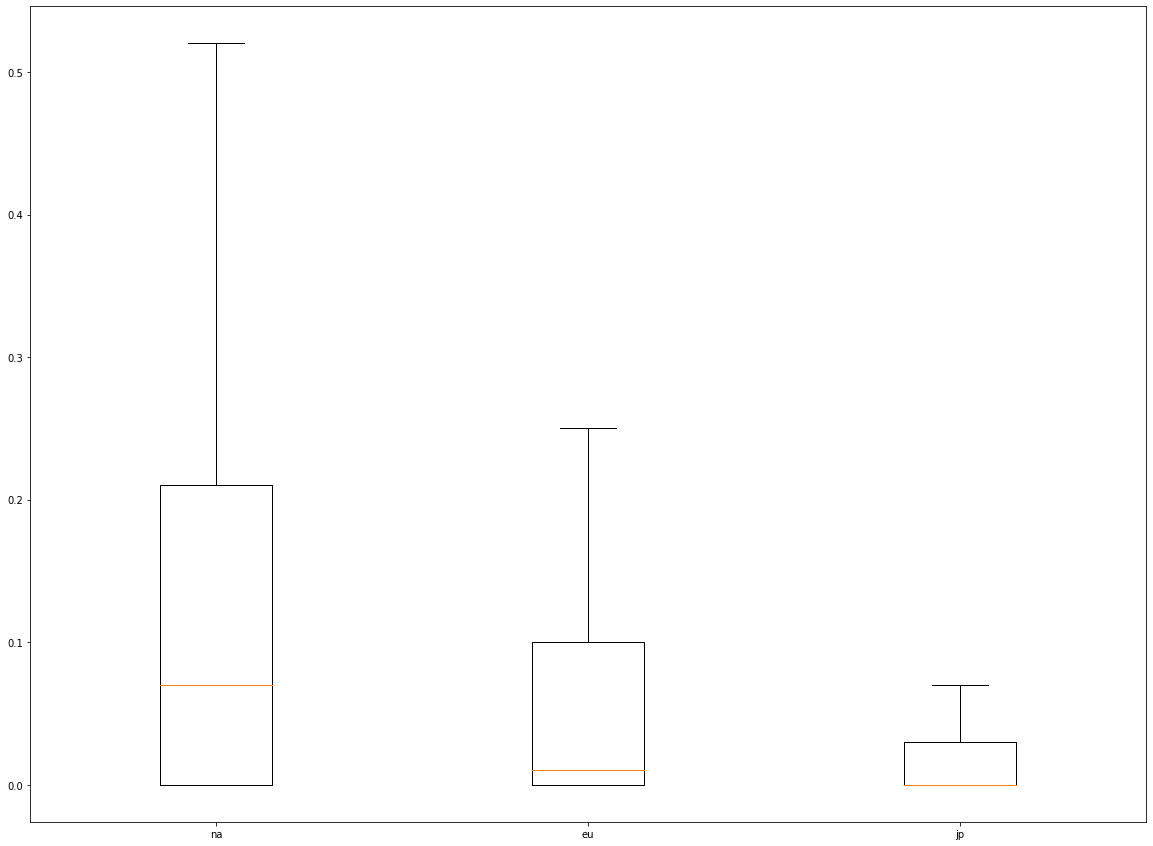

In [654]:
_, ax = plt.subplots(figsize=(20, 15))
ax.boxplot([games['{}_sales'.format(region)] for region in regions], labels=regions, showfliers=False)
plt.show()

### Conclusion

We see that top 5 platforms are different in other regions. In the same time top 5 genres on NA and EU doesn't differ so much as JP genres. Also we have no any difference between esrb ratings between regions, but they as themselves differ much

Also NA is the most profitable region

### Step 5. Test the following hypotheses

In [646]:
def test_means_of_2_populations(sample_1, sample_2, alpha=0.05):
    
    results = st.ttest_ind(sample_1.dropna(), sample_2.dropna())
    
    print('p-value: {}'.format(results.pvalue))
    
    if results.pvalue < alpha:
        print('We reject the null hypothesis')
    else:
        print("We can't reject the null hypothesis")

Null hypothesis always check equivalence of two values. And significance level should be small enough for us to be sure that significant differences are between values.

Now let's test first hypothesis:

H0 = Average user ratings of the Xbox One and PC platforms are the same.
<br>
H1 = Average user ratings of the Xbox One and PC platforms are not the same.

In [644]:
xone_users = games.query('platform == "XOne"')['user_score']
pc_users = games.query('platform == "PC"')['user_score']

In [645]:
test_means_of_2_populations(xone_users, pc_users)

p-value: 0.32234715579027784
We can't reject the null hypothesis


We see that these means have more in common than we thought so we need to do more precise analysis to be confident that these samples have different means

Let's test second hypothesis:

H0 = Average user ratings for the Action and Sports genres are equal.
<br>
H1 = Average user ratings for the Action and Sports genres are different.

In [647]:
action_users = games.query('genre == "Action"')['user_score']
sports_users = games.query('genre == "Sports"')['user_score']

In [648]:
test_means_of_2_populations(action_users, sports_users)

p-value: 5.861864396213929e-19
We reject the null hypothesis


We see that there is a significant difference between mean values of genres' samples.

In [649]:
# Let's check these means
action_users.describe()

count    1589.000000
mean        5.570673
std         3.187240
min        -1.000000
25%         5.000000
50%         6.800000
75%         7.700000
max         9.500000
Name: user_score, dtype: float64

In [650]:
sports_users.describe()

count    940.000000
mean       4.333511
std        3.617343
min       -1.000000
25%       -1.000000
50%        5.850000
75%        7.300000
max        9.300000
Name: user_score, dtype: float64

### Conclusion

We tested two hypothesis and see that user score does not differ much from platform to platform.

But there is a significant difference between Action and Sports.

### Step 6. Write a general conclusion

I analyzed the modern gaming market. The goal of the research is to determine patterns for comercial success games. 

So, if you want to make a lot of money in GameDev, you should deal Action on PS4 with E ESRB rating and be oriented on NA region as the most profitable (Sounds like the latest Spider-Man PS4 exclusive but it has rating T). 